/home/jake/.local/lib/python2.7/site-packages/ipykernel/__main__.py:68: RuntimeWarning: invalid value encountered in divide
/home/jake/anaconda2/lib/python2.7/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


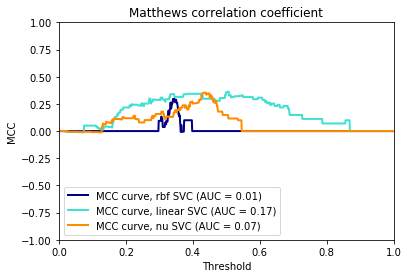

Theoretical max: 1.0


In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle
from scipy.integrate import quad

from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix, matthews_corrcoef
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, NuSVC

# import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target

# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
lw = 2

# Add noisy features
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# Split into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=random_state)

# Run classifiers
lsvc = SVC(kernel='linear', probability=True).fit(X_train, y_train)
rsvc = SVC(kernel='rbf', probability=True).fit(X_train, y_train)
nsvc = NuSVC(probability=True).fit(X_train, y_train)

y_scores = dict()
y_scores['linear'] = lsvc.predict_proba(X_test)
y_scores['rbf'] = rsvc.predict_proba(X_test)
y_scores['nu'] = nsvc.predict_proba(X_test)

# define multiclass MCC
def matthews_r(y_true, y_pred):
    # https://en.wikipedia.org/wiki/Matthews_correlation_coefficient#Multiclass_Case
    
    cm = confusion_matrix(y_true, y_pred)
    n_classes = cm.shape[0]
    
    sum_top = 0
    for k in range(n_classes):
        for l in range(n_classes):
            sum_top = sum_top + cm[k,k] * sum(cm[l,:]) - cm[k,l] * sum(cm[:,k])
            
    sum_left = 0
    for k in range(n_classes):
        sum_lefta = 0
        for kp in range(n_classes):
            if kp != k:
                sum_lefta = sum_lefta + sum(cm[kp,:])
        sum_left = sum_left + sum(cm[k,:]) * sum_lefta
    
    sum_right = 0
    for k in range(n_classes):
        sum_righta = 0
        for kp in range(n_classes):
            if kp != k:
                sum_righta = sum_righta + sum(cm[:,kp])
        sum_right = sum_right + sum(cm[:,k]) * sum_righta
        
    mcc = sum_top / np.sqrt(sum_left * sum_right)
    
    if np.isnan(mcc):
        return 0.
    else:
        return mcc

    
t_values = np.arange(0, 1, 1e-3)
matthews = dict()
m_func = dict()
for i in y_scores.keys():
    matthews[i] = [matthews_r(y_test, np.argmax(y_scores[i] >= t, axis=1)) for t in t_values]
    m_func[i] = lambda t: matthews_r(y_test, np.argmax(y_scores[i] >= t, axis=1))

# Plot Matthews curve for each class
plt.clf()
for i, color in zip(matthews.keys(), colors):
    plt.plot(t_values, matthews[i], color=color, lw=lw,
             label='MCC curve, %s SVC (AUC = %0.2f)' % (i, quad(m_func[i], 0, 1)[0]))

plt.xlim([0.0, 1.0])
plt.ylim([-1.0, 1.0])
plt.xlabel('Threshold')
plt.ylabel('MCC')
plt.title('Matthews correlation coefficient')
plt.legend(loc="lower left")
plt.show()

print('Theoretical max: %0.1f' % matthews_r(y_test, y_test))